## Getting started

This notebook shows the basic usage of the `PyRASA` package.

In [1]:
from neurodsp.sim import sim_combined
from neurodsp.utils import create_times
import numpy as np
import scipy.signal as dsp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('ticks')
sns.set_context('poster')

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

We first simulate a signal with a single oscillation and a spectral slope of -1

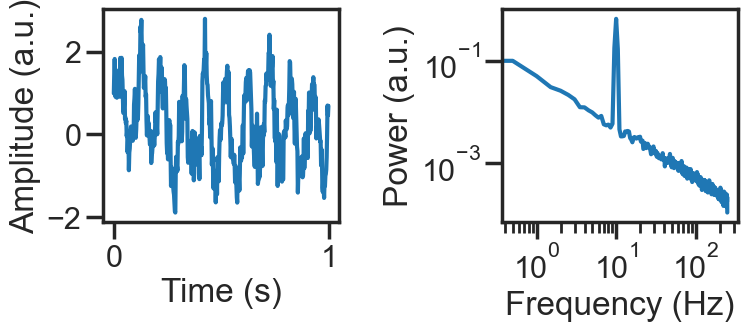

In [2]:
fs = 500
n_seconds = 60
duration=2
overlap=0.5

sim_components = {'sim_powerlaw': {'exponent' : -1}, 
                  'sim_oscillation': {'freq' : 10}}


sig = sim_combined(n_seconds=n_seconds, fs=fs, components=sim_components)
times = create_times(n_seconds=n_seconds, fs=fs)

max_times = times < 1
f, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].plot(times[max_times], sig[max_times])
axes[0].set_ylabel('Amplitude (a.u.)')
axes[0].set_xlabel('Time (s)')
freq, psd = dsp.welch(sig, fs=fs, nperseg=duration*fs, noverlap=duration*fs*overlap)
axes[1].loglog(freq, psd)
axes[1].set_ylabel('Power (a.u.)')
axes[1].set_xlabel('Frequency (Hz)')

plt.tight_layout()

Now we can use IRASA to seperate the signal in its periodic and aperiodic components

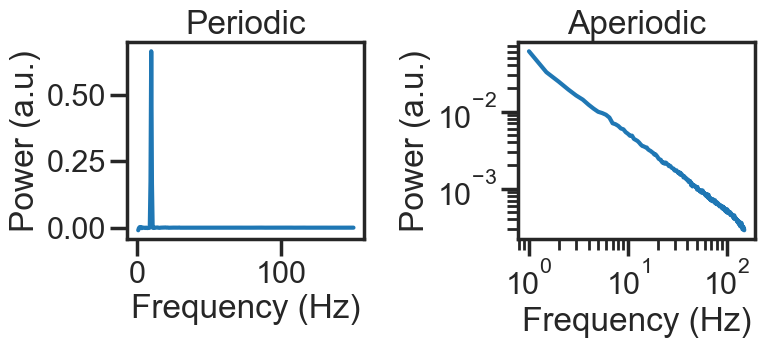

In [3]:
from pyrasa.irasa import irasa

freq_irasa, psd_ap, psd_p = irasa(sig, 
                                  fs=fs, 
                                  band=(1, 150), 
                                  kwargs_psd={'nperseg': duration*fs, 
                                             'noverlap': duration*fs*overlap
                                            },
                                hset_info=(1, 2, 0.05))

f, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].set_title('Periodic')
axes[0].plot(freq_irasa, psd_p[0,:])
axes[0].set_ylabel('Power (a.u.)')
axes[0].set_xlabel('Frequency (Hz)')
axes[1].set_title('Aperiodic')
axes[1].loglog(freq_irasa, psd_ap[0,:])
axes[1].set_ylabel('Power (a.u.)')
axes[1].set_xlabel('Frequency (Hz)')

f.tight_layout()


Now we can further analyse the periodic and aperiodic components using the `get_peak_params` and `compute_slope` functions, which will return pandas dataframes containing specific information about the slope or the oscillatory parameters.

In [4]:
# %% get periodic stuff
from pyrasa.utils.peak_utils import get_peak_params
get_peak_params(psd_p, freqs=freq_irasa)

,ch_name,cf,bw,pw
0,0,9.5,1.443135,0.420024


In [5]:
# %% get aperiodic stuff
from pyrasa.utils.aperiodic_utils import compute_slope

ap_params, gof_params = compute_slope(aperiodic_spectrum=psd_ap,
                                       freqs=freq_irasa, 
                                       fit_func='fixed')
ap_params

,Offset,Exponent,fit_type,ch_name
0,1.734754,1.018235,fixed,0


In [6]:
gof_params

,mse,r_squared,BIC,AIC,fit_type,ch_name
0,0.000335,0.998004,-2386.400882,-2390.101326,fixed,0


But how does all of this work in practice? The beauty of IRASA lies in its simplicity. Essentially, its just up/downsampling and averaging. I will deconstruct the algorithm below to show you its inner workings and highlight potential pitfalls.

We start by simply computing a psd

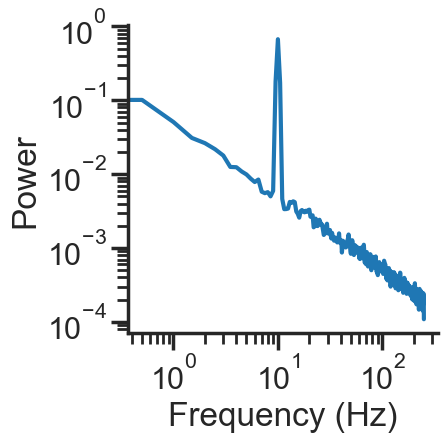

In [7]:
kwargs_psd = {'nperseg': duration*fs, 
              'noverlap': duration*fs*overlap}

freq, psd = dsp.welch(sig, fs=fs, **kwargs_psd)

f, ax = plt.subplots(figsize=(4,4))
ax.loglog(freq, psd)
ax.set_ylabel('Power')
ax.set_xlabel('Frequency (Hz)')
sns.despine()


Now we need to create two other psds from an up-/downsampled version of the data.
Note that the data is up-/downsampled by the same factor

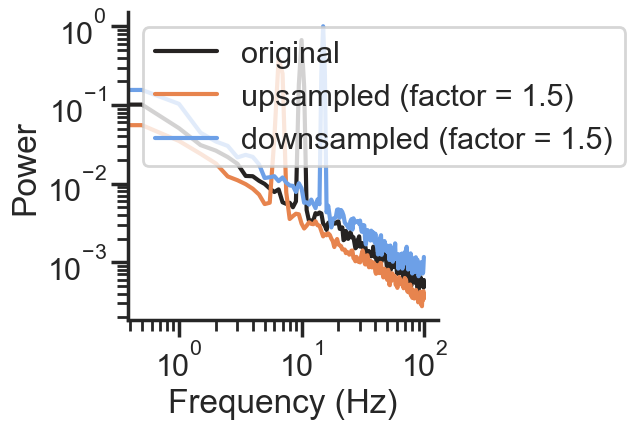

In [8]:
import fractions

resampling_factor = 1.5

def simple_rasa(resampling_factor):
    rat = fractions.Fraction(str(resampling_factor))
    up, down = rat.numerator, rat.denominator

    # Much faster than FFT-based resampling
    data_up = dsp.resample_poly(sig, up, down, axis=-1)
    data_down = dsp.resample_poly(sig, down, up, axis=-1)

    # Calculate an up/downsampled version of the PSD using same params as original
    _, psd_up = dsp.welch(data_up, fs * resampling_factor,  **kwargs_psd)
    _, psd_dw = dsp.welch(data_down, fs / resampling_factor, **kwargs_psd)

    return psd_up, psd_dw


psd_up, psd_dw = simple_rasa(resampling_factor)

pal = sns.diverging_palette(250, 30, l=65, center="dark", n=3)

f, ax = plt.subplots(figsize=(4,4))
f_max = freq < 100
ax.loglog(freq[f_max], psd[f_max], color=pal[1], label='original')
ax.loglog(freq[f_max], psd_up[f_max], color=pal[2], label='upsampled (factor = 1.5)')
ax.loglog(freq[f_max], psd_dw[f_max], color=pal[0], label='downsampled (factor = 1.5)')
ax.set_ylabel('Power')
ax.set_xlabel('Frequency (Hz)')
sns.despine()
plt.legend()

We can see that up-/downsampling shifted the peak (oscillation) in the spectrum relative to the original data.
Now we compute the geometric mean of the up-/downsampled version of the data and repeat the procedure for a different resampling factor.
We can see that this creates a version of the original data with 2 peaks that are shifted around the original peak by a factor of x.

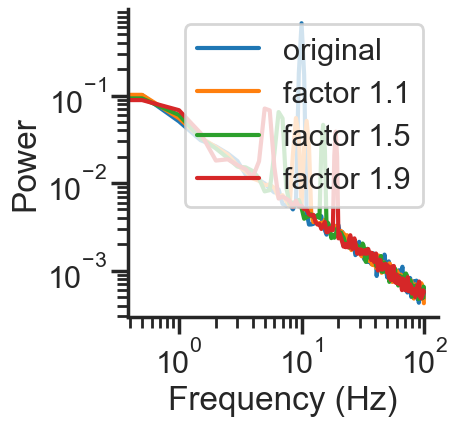

In [9]:

psd_up_19, psd_dw_19 = simple_rasa(1.9)
psd_up_11, psd_dw_11 = simple_rasa(1.1)

gmean = lambda x, y : np.sqrt(x * y)

f, ax = plt.subplots(figsize=(4,4))
f_max = freq < 100
ax.loglog(freq[f_max], psd[f_max], label='original')
ax.loglog(freq[f_max], gmean(psd_up_11, psd_dw_11)[f_max], label='factor 1.1')
ax.loglog(freq[f_max], gmean(psd_up, psd_dw)[f_max], label='factor 1.5')
ax.loglog(freq[f_max], gmean(psd_up_19, psd_dw_19)[f_max], label='factor 1.9')
ax.set_ylabel('Power')
ax.set_xlabel('Frequency (Hz)')

plt.legend()
sns.despine()

Now we can compute the median, between our 3 geometric means to obtain our aperiodic spectrum. In reality we use a bit more than 3 up-/downsampling factors, but on this data its enough to get a decent spectrum

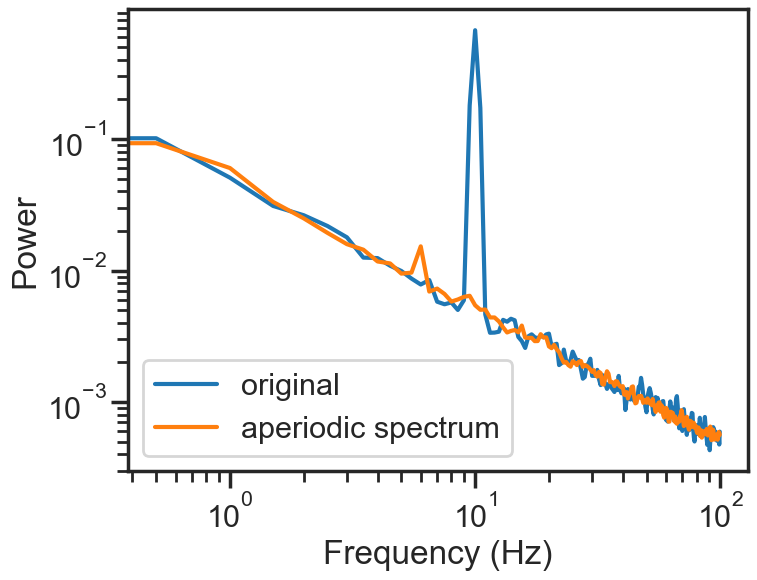

In [10]:
aperiodic_spectrum = np.median([gmean(psd_up_11, psd_dw_11),
                                gmean(psd_up, psd_dw),
                                gmean(psd_up_19, psd_dw_19)], axis=0)

f, ax = plt.subplots(figsize=(8,6))
f_max = freq < 100
ax.loglog(freq[f_max], psd[f_max], label='original')
ax.loglog(freq[f_max], aperiodic_spectrum[f_max], label='aperiodic spectrum')
ax.set_ylabel('Power')
ax.set_xlabel('Frequency (Hz)')

plt.legend()

But how do we get the periodic spectrum? Its actually quite simple. We just need to subtract our aperiodic spectrum from the original spectrum.

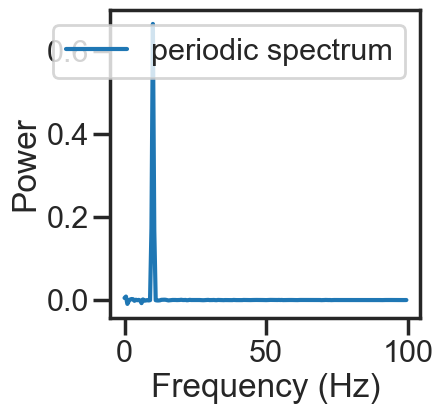

In [11]:
f, ax = plt.subplots(figsize=(4,4))
f_max = freq < 100
ax.plot(freq[f_max], psd[f_max] - aperiodic_spectrum[f_max], label='periodic spectrum')
ax.set_ylabel('Power')
ax.set_xlabel('Frequency (Hz)')

plt.legend()

Now we can do slope fits on the aperiodic spectrum or do peak detection on the periodic spectrum.
However, this was quite a simple spectrum and reality is usually much messsier and noisier. For instance we might get spectra that dont linearly decrease with frequency by the same value but have a deflection point (spectral knee) at which the slope starts changing. We can also deal with those using IRASA.
See below for how we would do this.

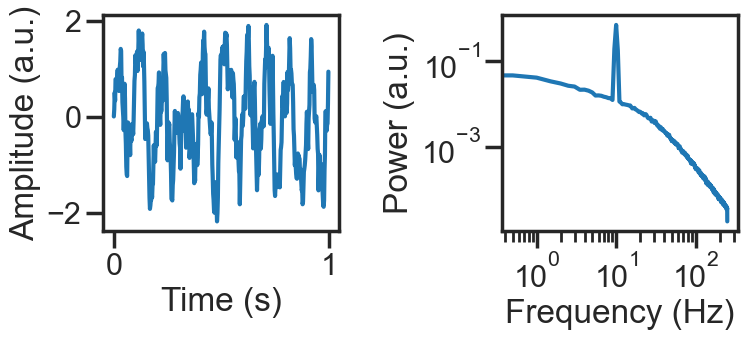

In [12]:
# %% Lets check the knee
knee_freq = 15
knee = knee_freq ** (2*.5 + 1.5)

sim_components = {'sim_knee': {'exponent1' : -.5, 'exponent2': -1.5, 'knee':knee }, 
                  'sim_oscillation': {'freq' : 10}}

sig = sim_combined(n_seconds=n_seconds, fs=fs, components=sim_components)
# %%
max_times = times < 1
f, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].plot(times[max_times], sig[max_times])
axes[0].set_ylabel('Amplitude (a.u.)')
axes[0].set_xlabel('Time (s)')
freq, psd = dsp.welch(sig, fs=fs, nperseg=duration*fs, noverlap=duration*fs*overlap)
axes[1].loglog(freq, psd)
axes[1].set_ylabel('Power (a.u.)')
axes[1].set_xlabel('Frequency (Hz)')

plt.tight_layout()

In [13]:
freq_irasa, psd_ap, psd_p = irasa(sig, 
                                  fs=fs, 
                                  band=(1, 150), 
                                  kwargs_psd={'nperseg': duration*fs, 
                                             'noverlap': duration*fs*overlap
                                            },
                                hset_info=(1, 2, 0.025))

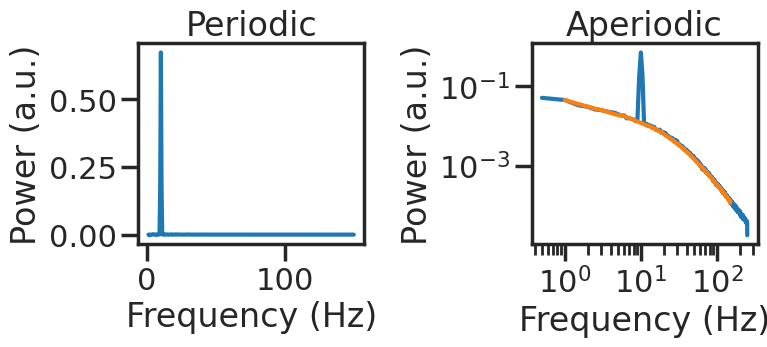

In [14]:
f, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].set_title('Periodic')
axes[0].plot(freq_irasa, psd_p[0,:])
axes[0].set_ylabel('Power (a.u.)')
axes[0].set_xlabel('Frequency (Hz)')
axes[1].set_title('Aperiodic')

axes[1].loglog(freq[1:], psd[1:])
axes[1].loglog(freq_irasa, psd_ap[0,:])
axes[1].set_ylabel('Power (a.u.)')
axes[1].set_xlabel('Frequency (Hz)')

f.tight_layout()

In [15]:
# %% get periodic stuff
from pyrasa.utils.peak_utils import get_peak_params
get_peak_params(psd_p, freqs=freq_irasa)


,ch_name,cf,bw,pw
0,0,10.0,1.435332,0.420089


In [16]:
# %% get aperiodic stuff
from pyrasa.utils.aperiodic_utils import compute_slope
ap_params_f, gof_params_f = compute_slope(aperiodic_spectrum=psd_ap, freqs=freq_irasa, fit_func='fixed')
ap_params_k, gof_params_k = compute_slope(aperiodic_spectrum=psd_ap, freqs=freq_irasa, fit_func='knee')


In [17]:
pd.concat([gof_params_f, gof_params_k])

,mse,r_squared,BIC,AIC,fit_type,ch_name
0,0.025889,0.935654,-1086.823648,-1090.524092,fixed,0
0,0.000057,0.999857,-2902.385348,-2913.486679,knee,0


In [19]:
ap_params_k

,Offset,Knee,Exponent_1,Exponent_2,Knee Frequency (Hz),fit_type,ch_name
0,0.004507,713.735174,0.53404,1.943573,8.861317,knee,0
